[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/generation/langchain/langgraph/01-gpt-4o-research-agent.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/generation/langchain/langgraph/01-gpt-4o-research-agent.ipynb)

# Research Agent in LangGraph, retrieve information from different LLMs and web search

Inspired by https://www.pinecone.io/learn/langgraph-research-agent/

**Research agents** are multi-step LLM agents that through multiple steps can produce in depth research reports on a topic of our choosing.

LangGraph agent that retrieve information form different LLMs and Tavily web search in order to respond to the request of the user.

So you need the keys to call the API of OpenAI, Tavily and HuggingFace.

In [113]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")
_set_if_undefined("HF_TOKEN")
_set_if_undefined("PINECONE_API_KEY")

## Graph State

We will define a custom graph state to support our agent-oriented decision making.

In [114]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

There are four parts to our agent state, those are:

* `input`: this is the user's most recent query, usually this would be a question that we want to answer with our research agent.
* `chat_history`: we are building a conversational agent that can support multiple interactions, to allow previous interactions to provide additional context throughout our agent logic we include the chat history in the agent state.
* `intermediate_steps`: provides a record of all steps the research agent will take between the user asking a question via `input` and the agent providing a final answer. These intermediate steps are crucial to allowing the agent to follow a path of coherent actions and ultimately producing an informed final answer.

## Custom Tools

We will define several tools for this agent that will focus on initial data discovery, that will allow the LLM to use more tools to research more deeply via a variety of different routes.

### General LLM Knowledge

Retrieve from the general knwoledge of different models (llama3.2:latest, mistral:latest, gpt-4o-mini)

You need to install Ollama https://ollama.com/
and pull the models

`ollama pull llama3.2`

`ollama pull mistral`

In [115]:
from langchain_ollama import ChatOllama

llmOlama = ChatOllama(model="llama3.2:latest")
results = llmOlama.invoke("What is LangGraph?")
print(results)
print(results.content)

content="LangGraph is an open-source Python library for working with graph neural networks (GNNs) and their variants. It provides a simple and efficient way to implement and train GNNs, making it easier to leverage the strengths of these models in various machine learning tasks.\n\nSome key features of LangGraph include:\n\n1. **Simplified GNN implementation**: LangGraph abstracts away many low-level details, allowing users to focus on designing their model's architecture without getting bogged down in the implementation.\n2. **High-performance computing**: LangGraph is optimized for performance and can handle large graphs with millions of nodes and edges.\n3. **Support for various GNN variants**: LangGraph supports a range of GNN variants, including Graph Convolutional Networks (GCNs), Graph Attention Networks (GATs), and Graph Neural Networks (GNNs) based on the GraphSAGE algorithm.\n4. **Easy integration with popular deep learning frameworks**: LangGraph can be easily integrated wit

Format the result

In [116]:
contexts = f"{results.content}\n[Info provided by {llmOlama.model}]"
print(contexts)

LangGraph is an open-source Python library for working with graph neural networks (GNNs) and their variants. It provides a simple and efficient way to implement and train GNNs, making it easier to leverage the strengths of these models in various machine learning tasks.

Some key features of LangGraph include:

1. **Simplified GNN implementation**: LangGraph abstracts away many low-level details, allowing users to focus on designing their model's architecture without getting bogged down in the implementation.
2. **High-performance computing**: LangGraph is optimized for performance and can handle large graphs with millions of nodes and edges.
3. **Support for various GNN variants**: LangGraph supports a range of GNN variants, including Graph Convolutional Networks (GCNs), Graph Attention Networks (GATs), and Graph Neural Networks (GNNs) based on the GraphSAGE algorithm.
4. **Easy integration with popular deep learning frameworks**: LangGraph can be easily integrated with popular deep l

We put this process in a tool

In [117]:
from langchain_core.tools import tool
from langchain_ollama import ChatOllama

@tool("llm_knowledge_llama")
def llm_knowledge_llama(query: str):
    """Finds general knowledge information using the knowlwdge of the LLM llama3.2, it's an inexpensive tool, but not very powerful."""
    try:
        llmLlama = ChatOllama(model="llama3.2:latest")
        results = llmLlama.invoke(query)
        contexts = f"{results.content}\n[Info provided by {llmLlama.model}]"
    except Exception as e:
        print(f"Error: {str(e)}")
        contexts = f"Error: {str(e)}"
    return contexts
    
@tool("llm_knowledge_mistral")
def llm_knowledge_mistral(query: str):
    """Finds general knowledge information using the knowlwdge of the LLM mistral, it's an inexpensive tool, but not very powerful."""
    try:
        llmMistral = ChatOllama(model="mistral:latest")
        results = llmMistral.invoke(query)
        contexts = f"{results.content}\n[Info provided by {llmMistral.model}]"
    except Exception as e:
        print(f"Error: {str(e)}")
        contexts = f"Error: {str(e)}"
    return contexts

@tool("llm_knowledge_gpt4o")
def llm_knowledge_gpt4o(query: str):
    """Finds general knowledge information using the knowlwdge of the LLM GTP-4o.mini, it's an expensive tool, but more powerful.
    Use this tool if you have not gotten relevant information from other tools"""
    try:
        llm = ChatOpenAI(model="gpt-4o-mini")
        results = llm.invoke(query)
        contexts = f"{results.content}\n[Info provided by gpt-4o-mini]"
    except Exception as e:
        print(f"Error: {str(e)}")
        contexts = f"Error: {str(e)}"
    return contexts

In [118]:
print(llm_knowledge_llama.invoke("What is LangGraph?"))

LangGraph is an open-source, modular framework for creating graph databases. It allows developers to build graph databases that support a wide range of query types and data models.

LangGraph was designed to be highly customizable and flexible, with a focus on simplicity and ease of use. It provides a high-level API that abstracts away many of the complexities of building a graph database from scratch, allowing developers to focus on modeling their data and writing queries.

Some key features of LangGraph include:

1. Modular architecture: LangGraph is designed as a collection of modular components that can be easily extended or replaced.
2. Query language: LangGraph has its own query language, which allows developers to write queries in a declarative style.
3. Data model: LangGraph supports a wide range of data models, including nodes, edges, and properties.
4. Indexing: LangGraph provides support for indexing, which allows for efficient querying of graph data.
5. Acquaintance with va

### Web Search

The web search tool will provide the agent with access to web search. It will be instructed to use this for more general knowledge queries.

In [119]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search = TavilySearchResults(max_results=3, include_answer=True, include_raw_content=True, include_images=True)
results = web_search.invoke("What is LangGraph?")
print(results)

[{'url': 'https://www.langchain.com/langgraph', 'content': 'LangGraph is a stateful, orchestration framework that brings added control to agent workflows. LangGraph Cloud is a service for deploying and scaling LangGraph applications, with a built-in Studio for prototyping, debugging, and sharing LangGraph applications.'}, {'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial', 'content': 'LangGraph is a library within the LangChain ecosystem designed to tackle these challenges head-on. LangGraph provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured manner. It simplifies the development process by enabling the creation of cyclical graphs, which are essential for developing'}, {'url': 'https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787', 'content': "LangGraph is a low-level framework that offers extensive customisation options, allowing you to build precisely what you need. Since LangGra

In [120]:
contexts = "\n---\n".join(
    ["\n".join([x["content"], x["url"]]) for x in results]
)

print(contexts)

LangGraph is a stateful, orchestration framework that brings added control to agent workflows. LangGraph Cloud is a service for deploying and scaling LangGraph applications, with a built-in Studio for prototyping, debugging, and sharing LangGraph applications.
https://www.langchain.com/langgraph
---
LangGraph is a library within the LangChain ecosystem designed to tackle these challenges head-on. LangGraph provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured manner. It simplifies the development process by enabling the creation of cyclical graphs, which are essential for developing
https://www.datacamp.com/tutorial/langgraph-tutorial
---
LangGraph is a low-level framework that offers extensive customisation options, allowing you to build precisely what you need. Since LangGraph is built on top of LangChain, it's seamlessly integrated into its ecosystem, making it easy to leverage existing tools and components. However, there are

We put this process into a tool:

In [121]:
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

@tool("web_search")
def web_search(query: str):
    """Finds general knowledge information using Tavily Web Search. Can also be used
    to augment more 'general' knowledge to a previous specialist query.
    It's an inexpensive tool, but it can find recent and niche information."""
    web_search = TavilySearchResults(max_results=3, include_answer=True, include_raw_content=True, include_images=True)
    results = web_search.invoke(query)
    contexts = "\n---\n".join(
        ["\n".join([x["content"], x["url"]]) for x in results]
    )
    return contexts

### RAG

We setup a collection in Pinecone taking info from a the prechuncket dataset v2 of the AI ArXiv dataset, available on Hugging Face Datasets at [`jamescalam/ai-arxiv2-chunks`](https://huggingface.co/datasets/jamescalam/ai-arxiv2-chunks)

In [123]:
from datasets import load_dataset

# Ask the user if they want to run the code block
load_dataset = input("Do you want to load the dataset form Hugging Face? (y/n): ")

if load_dataset.lower() == 'y':
    dataset = load_dataset("jamescalam/ai-arxiv2-semantic-chunks", split="train")
    dataset
    dataset[0]
else:
    print("Dataset not loaded.")

Do you want to load the dataset form Hugging Face? (y/n):  n


Dataset not loaded.


Build the knwoledge base on Pinecone

In [124]:
import os
from getpass import getpass
from semantic_router.encoders import OpenAIEncoder

encoder = OpenAIEncoder(name="text-embedding-3-small")

In [125]:
from pinecone import Pinecone
from pinecone import ServerlessSpec

# initialize connection to pinecone (get API key at app.pinecone.io)
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY") or getpass("Pinecone API key: ")

# configure client
pc = Pinecone(api_key=PINECONE_API_KEY)

spec = ServerlessSpec(
    cloud="aws", region="us-east-1"   #us-west-2
)

dims = len(encoder(["some random text"])[0])
dims

1536

In [126]:
import time

index_name = "langgraph-research-agent"

if load_dataset.lower() == 'y':
    # check if index already exists (it shouldn't if this is first time)
    if index_name not in pc.list_indexes().names():
        # if does not exist, create index
        pc.create_index(
            index_name,
            dimension=dims,  # dimensionality of embed 3
            metric='dotproduct',
            spec=spec
        )
        # wait for index to be initialized
        while not pc.describe_index(index_name).status['ready']:
            time.sleep(1)
else:
    print("Skipped...")
    
# connect to index
indexPinecone = pc.Index(index_name)
time.sleep(1)
# view indexPinecone stats
indexPinecone.describe_index_stats()

Skipped...


{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 10000}},
 'total_vector_count': 10000}

Populate the knowledge base with the Hugging Face dataset

In [131]:
from tqdm.auto import tqdm

if load_dataset.lower() == 'y':
    # easier to work with dataset as pandas dataframe
    data = dataset.to_pandas().iloc[:10000]
    
    batch_size = 128
    
    for i in tqdm(range(0, len(data), batch_size)):
        i_end = min(len(data), i+batch_size)
        batch = data[i:i_end].to_dict(orient="records")
        # get batch of data
        metadata = [{
            "title": r["title"],
            "content": r["content"],
            "arxiv_id": r["arxiv_id"],
            "references": r["references"].tolist()
        } for r in batch]
        # generate unique ids for each chunk
        ids = [r["id"] for r in batch]
        # get text content to embed
        content = [r["content"] for r in batch]
        # embed text
        embeds = encoder(content)
        # add to Pinecone
        indexPinecone.upsert(vectors=zip(ids, embeds, metadata))
else:
    print("Skipped...")

# test a search on Pinecone
xq = encoder(["Llama"])
xc = indexPinecone.query(vector=xq, top_k=2, include_metadata=True)
print(xc)

Skipped...
{'matches': [{'id': '2310.12773#56',
              'metadata': {'arxiv_id': '2310.12773',
                           'content': 'Stanford alpaca: An '
                                      'instruction-following llama model, '
                                      '2023. Hugo Touvron, Thibaut Lavril, '
                                      'Gautier Izacard, Xavier Martinet, '
                                      'Marie-Anne Lachaux, TimothÂ´ee Lacroix, '
                                      'Baptiste Rozi`ere, Naman Goyal, Eric '
                                      'Hambro, Faisal Azhar, Aurelien '
                                      'Rodriguez, Ar- mand Joulin, Edouard '
                                      'Grave, and Guillaume Lample. Llama:',
                           'references': ['2302.13971'],
                           'title': 'Safe RLHF: Safe Reinforcement Learning '
                                    'from Human Feedback'},
              'score': 0.47682

RAG Tools

In [128]:
from langchain_core.tools import tool

def format_rag_contexts(matches: list):
    contexts = []
    for x in matches:
        text = (
            f"Title: {x['metadata']['title']}\n"
            f"Content: {x['metadata']['content']}\n"
            f"ArXiv ID: {x['metadata']['arxiv_id']}\n"
            f"Related Papers: {x['metadata']['references']}\n"
        )
        contexts.append(text)
    context_str = "\n---\n".join(contexts)
    return context_str

@tool("rag_search_filter")
def rag_search_filter(query: str, arxiv_id: str):
    """Finds information from our ArXiv database using a natural language query
    and a specific ArXiv ID. Allows us to learn more details about a specific paper."""
    xq = encoder([query])
    xc = indexPinecone.query(vector=xq, top_k=6, include_metadata=True, filter={"arxiv_id": arxiv_id})
    context_str = format_rag_contexts(xc["matches"])
    return context_str

@tool("rag_search")
def rag_search(query: str):
    """Finds specialist information on AI using a natural language query."""
    xq = encoder([query])
    xc = indexPinecone.query(vector=xq, top_k=2, include_metadata=True)
    context_str = format_rag_contexts(xc["matches"])
    return context_str

### Final Answer

Finally, we define a "final answer" tool. This isn't a tool in the usual sense, instead we use it to force a particular output format from our LLM via the function/tool calling.

In [100]:
@tool("final_answer")
def final_answer(
    introduction: str,
    research_steps: str,
    main_body: str,
    conclusion: str,
    differences: str,
    sources: str
):
    """Returns a natural language response to the user in the form of a research
    report. There are several sections to this report, those are:
    - `introduction`: a short paragraph introducing the user's question and the
    topic we are researching.
    - `research_steps`: a few bullet points explaining the steps that were taken
    to research your report.
    - `main_body`: this is where the bulk of high quality and concise
    information that answers the user's question belongs. It is 3-4 paragraphs
    long in length.
    - `conclusion`: this is a short single paragraph conclusion providing a
    concise but sophisticated view on what was found.
    - `differences`: any differences between the information taken from the different
    sources, if there are no differences that the sources are not inconsistent with each other.
    - `sources`: a bulletpoint list provided detailed sources for all information
    referenced during the research process, please for LLM indacate the model used.
    """
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])
    return ""

## Initialize the "Oracle"

The **Oracle** LLM is our graph's decision maker. It decides which path we should take down our graph. It functions similarly to an agent but is much simpler and reliable.

The Oracle consists of an LLM provided with a set of potential function calls (ie our tools) that it can decide to use — we force it to use _at least_ one of those tool using the `tool_choice="any"` setting (see below). Our Oracle only makes the decision to use a tool, it doesn't execute the tool code itself (we do that seperately in our graph).

### Oracle Prompt

Our prompt for the Oracle will emphasize it's decision making ability within the `system_prompt`, leave a placeholder for us to later insert `chat_history`, and provide a place for us to insert the user `input`.

In [101]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

system_prompt = """You are the oracle, the great AI decision maker.
Given the user's query you must decide what to do with it based on the
list of tools provided to you.

If you see that a tool has been used (in the scratchpad) with a particular
query, do NOT use that same tool with the same query again. Also, use the
llm knowledge tool only once for a model (ie, if the tool appears in the 
scratchpad once, do not use it again, but you can use different models) 
for other tools do NOT use more than twice (ie, if the tool appears in the 
scratchpad twice, do not use it again).
If the request is very specific it is preferable to use the most powerful tool 
even if more expensive.

You should aim to collect information from a diverse range of sources before
providing the answer to the user. Once you have collected plenty of information
to answer the user's question (stored in the scratchpad) use the final_answer
tool.
Start looking for information from the cheapest tools.
"""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    ("assistant", "scratchpad: {scratchpad}"),
])

Next, we must initialize our `llm` (for this we use `gpt-4o`) and then create the _runnable_ pipeline of our Oracle.

The runnable connects our inputs (the user `input` and `chat_history`) to our `prompt`, and our `prompt` to our `llm`. It is also where we _bind_ our tools to the LLM and enforce function calling via `tool_choice="any"`.

Test the agent quickly to confirm it is functional:

In [102]:
from langchain_core.messages import ToolCall, ToolMessage
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o",
    openai_api_key=os.environ["OPENAI_API_KEY"],
    temperature=0
)

tools=[
    llm_knowledge_gpt4o,
    llm_knowledge_llama,
    llm_knowledge_mistral,
    web_search,
    rag_search_filter,
    rag_search,
    final_answer
]

# define a function to transform intermediate_steps from list
# of AgentAction to scratchpad string
def create_scratchpad(intermediate_steps: list[AgentAction]):
    research_steps = []
    for i, action in enumerate(intermediate_steps):
        if action.log != "TBD":
            # this was the ToolExecution
            research_steps.append(
                f"Tool: {action.tool}, input: {action.tool_input}\n"
                f"Output: {action.log}"
            )
    return "\n---\n".join(research_steps)

oracle = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: x["chat_history"],
        "scratchpad": lambda x: create_scratchpad(
            intermediate_steps=x["intermediate_steps"]
        ),
    }
    | prompt
    | llm.bind_tools(tools, tool_choice="any")
)

In [103]:
inputs = {
    "input": "What is LangGraph?",
    "chat_history": [],
    "intermediate_steps": [],
}
out = oracle.invoke(inputs)
out

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_PzhWl3ko0l7ViUguzgWZ02EK', 'function': {'arguments': '{"query": "LangGraph"}', 'name': 'llm_knowledge_llama'}, 'type': 'function'}, {'id': 'call_zKb189GmEYQwQfH7RYTscxkZ', 'function': {'arguments': '{"query": "LangGraph"}', 'name': 'llm_knowledge_mistral'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 785, 'total_tokens': 840, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_9e15ccd6a4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-899eefe3-00cf-4c86-a6b2-1115e6df49a6-0', tool_calls=[{'name': 'llm_knowledge_llama', 'args': {'query': 'LangGraph'}, 'id': 'call_PzhWl3ko0l7ViUguzgWZ02EK', 'type': 'tool_call'}, {'name': 'llm_knowledge_mistral', 'args': {'query': 'LangGraph'}, 'id': 'c

It is running but we are returning a lot of output here, we can narrow this down to what we need — ie, the chosen tool name and generated input args for the tool.

In [104]:
for index, call in enumerate(out.tool_calls, start=1):
    print(f"{index}. {call.get('name', 'not found')} {call.get('args', '')}")

1. llm_knowledge_llama {'query': 'LangGraph'}
2. llm_knowledge_mistral {'query': 'LangGraph'}


We can see now that our Oracle decided to use the cheapest tool.

## Define Nodes for Graph

We will be passing the tool use decision to our `router` which will _route_ the output to the chosen node component to run (we define these below) based on the `out.tool_calls[0]["name"]` value.

In [105]:
def run_oracle(state: list):
    print("run_oracle")
    print(f"intermediate_steps: {state['intermediate_steps']}")
    out = oracle.invoke(state)
    tool_name = out.tool_calls[0]["name"]
    tool_args = out.tool_calls[0]["args"]
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log="TBD"
    )
    return {
        "intermediate_steps": [action_out]
    }

def router(state: list):
    # return the tool name to use
    if isinstance(state["intermediate_steps"], list):
        return state["intermediate_steps"][-1].tool
    else:
        # if we output bad format go to final answer
        print("Router invalid format")
        return "final_answer"

All of our tools can be run using the same function logic, which we define with `run_tool`. The input parameters to our tool call and the resultant output are added to our graph state's `intermediate_steps` parameter.

In [106]:
tool_str_to_func = {
    "llm_knowledge_gpt4o": llm_knowledge_gpt4o,
    "llm_knowledge_llama": llm_knowledge_llama,
    "llm_knowledge_mistral": llm_knowledge_mistral,
    "web_search": web_search,
    "rag_search_filter": rag_search_filter,
    "rag_search": rag_search,
    "final_answer": final_answer
}

def run_tool(state: list):
    # use this as helper function so we repeat less code
    tool_name = state["intermediate_steps"][-1].tool
    tool_args = state["intermediate_steps"][-1].tool_input
    print(f"{tool_name}.invoke(input={tool_args})")
    # run tool
    out = tool_str_to_func[tool_name].invoke(input=tool_args)
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(out)
    )
    return {"intermediate_steps": [action_out]}

## Define Graph

In [107]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("oracle", run_oracle)
graph.add_node("llm_knowledge_gpt4o", run_tool)
graph.add_node("llm_knowledge_llama", run_tool)
graph.add_node("llm_knowledge_mistral", run_tool)
graph.add_node("web_search", run_tool)
graph.add_node("rag_search_filter", run_tool)
graph.add_node("rag_search", run_tool)
graph.add_node("final_answer", run_tool)

graph.set_entry_point("oracle")

graph.add_conditional_edges(
    source="oracle",  # where in graph to start
    path=router,  # function to determine which node is called
)

# create edges from each tool back to the oracle
for tool_obj in tools:
    if tool_obj.name != "final_answer":
        graph.add_edge(tool_obj.name, "oracle")

# if anything goes to final answer, it must then move to END
graph.add_edge("final_answer", END)

runnable = graph.compile()

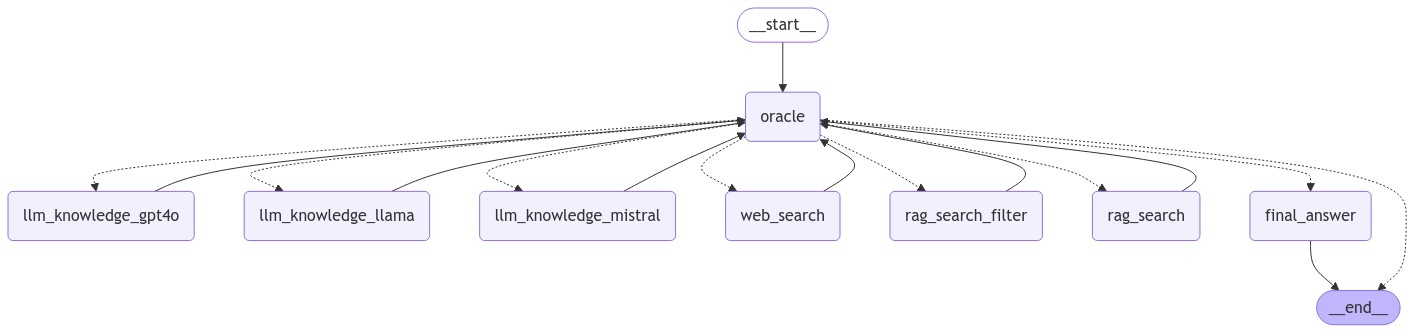

In [108]:
from IPython.display import Image, display

display(Image(runnable.get_graph().draw_mermaid_png()))


## Building Reports

Let's test our research agent. First, I want to try on something simple (although not within the intended use-case of our agent):

In [89]:
out = runnable.invoke({
    "input": "What is LangGraph?",
    "chat_history": [],
})

run_oracle
intermediate_steps: []
llm_knowledge_llama.invoke(input={'query': 'LangGraph'})
run_oracle
intermediate_steps: [AgentAction(tool='llm_knowledge_llama', tool_input={'query': 'LangGraph'}, log='TBD'), AgentAction(tool='llm_knowledge_llama', tool_input={'query': 'LangGraph'}, log="LangGraph is a lightweight graph database designed for the Go programming language. It's primarily used for building graph-based applications, such as social networks, recommendation systems, and knowledge graphs.\n\nHere are some key features of LangGraph:\n\n1. **In-memory data storage**: LangGraph stores data in memory by default, which provides faster query performance and better scalability.\n2. **High-performance queries**: LangGraph supports high-performance queries using CQL (Cypher-like query language) or SQL.\n3. **Graph traversal algorithms**: LangGraph includes built-in support for graph traversal algorithms like Dijkstra's algorithm and Breadth-First Search (BFS).\n4. **Data modeling**: L

Let's create a function to consume the agent output and format it into our report:

In [90]:
def build_report(output: dict):
    research_steps = output["research_steps"]
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    sources = output["sources"]
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])
    return f"""
INTRODUCTION
------------
{output["introduction"]}

RESEARCH STEPS
--------------
{research_steps}

REPORT
------
{output["main_body"]}

CONCLUSION
----------
{output["conclusion"]}

DIFFERENCES
----------
{output["differences"]}

SOURCES
-------
{sources}
"""

In [91]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
LangGraph is a versatile framework designed for creating stateful, multi-actor applications using large language models (LLMs). It is part of the LangChain ecosystem and is used to build complex, multi-agent workflows.

RESEARCH STEPS
--------------
- Conducted a search using the Llama LLM to gather initial information about LangGraph.
- Performed a web search to find more detailed and specific information about LangGraph and its applications.

REPORT
------
LangGraph is a framework that facilitates the development of applications involving multiple language agents. It is particularly useful for creating stateful, flexible, and scalable systems. The framework allows developers to construct applications as graphs, where nodes represent different agents or processes, and edges define the interactions or data flow between these nodes. This graph-based approach is beneficial for managing complex workflows and ensuring that the system can handle multiple tasks sim

Now let's try with an on-topic question on AI.

In [109]:
out = runnable.invoke({
    "input": "Cycles and Branching in LangGraph",
    "chat_history": []
})

run_oracle
intermediate_steps: []
rag_search.invoke(input={'query': 'Cycles and Branching in LangGraph'})
run_oracle
intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'Cycles and Branching in LangGraph'}, log='TBD'), AgentAction(tool='rag_search', tool_input={'query': 'Cycles and Branching in LangGraph'}, log='Title: GPT-4 Doesn\'t Know It\'s Wrong: An Analysis of Iterative Prompting for Reasoning Problems\nContent: are unlikely to do well on graphs with over twenty nodes. Therefore, we built our own dataset. We use GrinPy2 to handle common graph operations. Each graph is constructed using the ErdË osâ RÃ©nyi method (p = 0.4), modified so that any generation that fails to be planar or happens to be isomorphic to a previously generated one is retried. Once a successful candidate is found, it is compiled into the standard DIMACS format[1], appended with a comment containing its precalculated chromatic number. For the following experiments, we generated 100 instance

In [110]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
LangGraph is a framework designed to facilitate the development of stateful, multi-actor applications using large language models (LLMs). It is particularly noted for its ability to implement cycles and branching, which are crucial for creating complex workflows in applications.

RESEARCH STEPS
--------------
- Conducted a RAG search to find specialist information on LangGraph and its features.
- Performed a web search to gather additional insights and recent developments related to LangGraph.

REPORT
------
LangGraph is a powerful tool for building applications that require complex workflows involving cycles and branching. It is part of the LangChain ecosystem, which is a framework for developing applications based on large language models. LangGraph stands out due to its ability to handle cycles and branching, which are essential for creating dynamic and flexible workflows. 

Cycles in LangGraph allow for the implementation of loops within applications. Thi

Let's ask about RAG specifically.

In [111]:
out = runnable.invoke({
    "input": "what is retrieval augmented generation?",
    "chat_history": []
})

run_oracle
intermediate_steps: []
llm_knowledge_llama.invoke(input={'query': 'retrieval augmented generation'})
run_oracle
intermediate_steps: [AgentAction(tool='llm_knowledge_llama', tool_input={'query': 'retrieval augmented generation'}, log='TBD'), AgentAction(tool='llm_knowledge_llama', tool_input={'query': 'retrieval augmented generation'}, log="Retrieval Augmented Generation (RAG) is a type of deep learning algorithm used for text generation tasks, such as generating text summaries or answering questions. It combines the strengths of two popular architectures:\n\n1. **Retrieval**: This involves retrieving relevant information from a knowledge base or database.\n2. **Augmentation**: This involves augmenting the retrieved information with additional context, such as user queries or external knowledge sources.\n\nThe RAG architecture typically consists of three main components:\n\n1. **Knowledge Retrieval**: A neural network that retrieves relevant information from a knowledge base 

In [112]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
Retrieval Augmented Generation (RAG) is an advanced technique in natural language processing that enhances the capabilities of text generation models by integrating retrieval mechanisms.

RESEARCH STEPS
--------------
- Utilized the Llama3.2 model to gather a detailed explanation of RAG.
- Employed the Mistral model to obtain additional insights into the workings and applications of RAG.

REPORT
------
Retrieval Augmented Generation (RAG) is a sophisticated approach in the field of natural language processing that combines the strengths of retrieval systems and generative models. The primary goal of RAG is to improve the accuracy and contextual relevance of text generation tasks, such as question answering, text summarization, and conversational AI.

The RAG architecture typically involves three main components: a knowledge retrieval system, a question encoder, and an answer generator. The process begins with the question encoder, which processes the user que

Let's ask about recent financial results, probably the best source will be web search.

In [63]:
out = runnable.invoke({
    "input": "provide information about Microsoft's 2024 financial results",
    "chat_history": []
})

run_oracle
intermediate_steps: []
web_search.invoke(input={'query': 'Microsoft 2024 financial results'})
run_oracle
intermediate_steps: [AgentAction(tool='web_search', tool_input={'query': 'Microsoft 2024 financial results'}, log='TBD'), AgentAction(tool='web_search', tool_input={'query': 'Microsoft 2024 financial results'}, log='Earnings Release FY24 Q4. Microsoft Cloud Strength Drives Fourth Quarter Results. REDMOND, Wash. — July 30, 2024 — Microsoft Corp. today announced the following results for the quarter ended June 30, 2024, as compared to the corresponding period of last fiscal year: · Revenue was $64.7 billion and increased 15% (up 16% in constant currency)\nhttps://www.microsoft.com/en-us/investor/earnings/FY-2024-Q4/press-release-webcast\n---\nOctober 30, 2024 | Microsoft Source. Share on Facebook (opens new window) Share on LinkedIn (opens new window) Share on X (opens new window) REDMOND, Wash. — Oct. 30, 2024 — Microsoft Corp. on Wednesday announced that fiscal year 2025 

In [64]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
Microsoft's financial results for 2024 reflect the company's continued growth and strength, particularly in its cloud services and commercial products. The results highlight significant revenue increases across various sectors, showcasing Microsoft's robust performance in the technology market.

RESEARCH STEPS
--------------
- Conducted a web search for Microsoft's 2024 financial results to gather the most recent and relevant data.

REPORT
------
In the fiscal year 2024, Microsoft reported a revenue of $64.7 billion for the fourth quarter, marking a 15% increase compared to the same period in the previous year. This growth was driven by the company's strong performance in cloud services, with Microsoft Cloud revenue increasing by 22% year-over-year. The commercial products and cloud services segment, including Microsoft 365, also saw substantial growth, with a 13% increase in revenue, driven by a 15% rise in Microsoft 365 Commercial cloud revenue. 

The consu

In [65]:
out = runnable.invoke({
    "input": "write the history of Italy",
    "chat_history": []
})

run_oracle
intermediate_steps: []
llm_knowledge_llama.invoke(input={'query': 'history of Italy'})
run_oracle
intermediate_steps: [AgentAction(tool='llm_knowledge_llama', tool_input={'query': 'history of Italy'}, log='TBD'), AgentAction(tool='llm_knowledge_llama', tool_input={'query': 'history of Italy'}, log='Italy has a rich and complex history that spans over 2,500 years. Here\'s an overview:\n\n**Ancient Italy (8th century BC - 476 AD)**\n\n* The Italian peninsula was inhabited by various tribes, including the Latins, Etruscans, and Greeks.\n* In the 8th century BC, the Romans conquered much of Italy, founding the city of Rome in 753 BC.\n* The Roman Empire expanded throughout Italy, establishing a system of government, laws, and infrastructure that lasted for centuries.\n* During this period, the Etruscan civilization flourished in central Italy, leaving behind art, architecture, and engineering feats.\n\n**Middle Ages (476 - 1300)**\n\n* In 476 AD, the Western Roman Empire fell to

In [66]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
Italy's history is a rich tapestry of cultural, political, and social evolution, spanning over three millennia. From the rise of the Roman Empire to the Renaissance and modern-day Italy, the country's past is marked by significant events and influential figures.

RESEARCH STEPS
--------------
- Utilized the LLM knowledge of llama3.2 to gather a broad overview of Italy's history.
- Consulted the LLM knowledge of mistral for additional insights and details on key historical periods.
- Leveraged the LLM knowledge of gpt-4o-mini for a comprehensive and detailed account of Italy's historical timeline.

REPORT
------
Italy's history begins in prehistoric times, with human presence dating back to the Paleolithic era. The Etruscans, a significant civilization, influenced early Roman culture. Rome's foundation in 753 BC marked the beginning of the Roman Kingdom, which evolved into the Roman Republic in 509 BC. The Republic expanded through military conquests, leading 